<a href="https://colab.research.google.com/github/K-Chorna02/DST_Assessment_2/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal statement here
To discuss:
- Scaling performance in terms of data volume and resource allocated

- Parallelism via GPUs

- Comparison between parallel and single-machine problems



• additional implementation if an oﬀ-the-shelf implementation falls
short,
• exploring multiple implementations,
• examining the mathematical details of choices.
identifying an appropriate dataset;
• using your understanding of the structure of datasets to make ar-
guments comparing the dataset you chose to one that you might
encounter in a “real” data-science setting;
• plotting or otherwise describing various inputs, outputs, or parame-
ters.
(c) the correctness of the methods used to achieve their stated goals.
(d) the robustness of the results in supporting the conclusions.




# Introduction


**To include in intro: Clearly outline our goal (choose an appropriate scientific/analysis question) , discuss our goal in more detail here, mention how we would scale to a deployable data-science solution. **


We focus on Image classification using Convolutional Neural Networks. Our goal is to investigate how different optimisation strategies and model architectures affect classification accuracy and robustness, and to determine which methods generalise best when scaled to more complex and realistic datasets.

Throughout our project we each carried out a related task to learn more about Neural Networks.
We began exploring CIFAR-10 which we treated as a toy dataset to learn more about optimisation and how the changing of hyperparameters affects the performance of models.
We then generalised to a more realistic dataset,(Food 101) where we created commonly seen CNN models from scratch (ResNet18 and ViT models).

Finally, we tested their robustness by changing our test sets to make them harder for the model to look at, e.g. adding Gaussian blur or changing the brightness of our images.

**Mention: Why we've chosen this **



In [ ]:
#Loading necessary libraries
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt #for plotting
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import Subset

#libraries used for EDA
import torch
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import entropy

#libraries used for Robustness
import torch
import numpy as np
import cv2
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


## About our datasets
### CIFAR-10

The CIFAR-10 dataset can be found online at: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

This is a widely used benchmark dataset created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, used for image classification in machine learning methods.

It consists of 60,000 sets of 32x32 images split into 10 classes, such as planes, cars, birds, cats, etc. Of these 50,000 are sued for training and the remaining 10,000 are used for testing.
This makes it a perfect starting point for our project, serving as a toy dataset to better understand neural networks. Due to its low resolution, we are able to explore the impacts of different hyperparameters and hence optimize our neural network.


By experimenting and exploring the effects of different optimization approaches on CIFAR-10, we aim to understand which approaches generalise well before applying them to larger and more complex datasets.
We note some may improve performance specifically on this data set but not generalise so well.

Below we load CIFAR-10:




In [ ]:
batch_size = 10 #we can vary the batch size, but this basically shows that ...

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) # discuss transforms

In [ ]:
#downloading
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#info
print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")
print(f"Classes: {trainset.classes}")


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Training samples: 50000
Testing samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Now we've loaded the data and we can see the classes and distribution of testing vs training, we can now visualise a small sample (10 images) of the data:

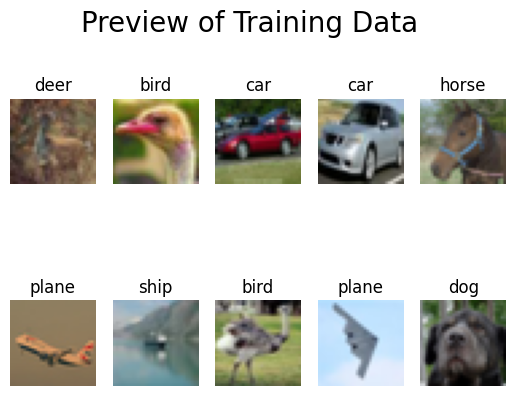

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(trainloader)
images, labels = next(dataiter) #slight modification here to account for python update

for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions (SEE CELL BELOW)
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

Why CIFAR-10 helps you explore these?
How it fits into your project goals?

Since this datasets has been collected in an artificial environment and transformed, weknow that there is an even class distribution and the data has already been split into training and testing.


In [ ]:
from collections import Counter
labels = [label for _, label in trainset]
label_counts = Counter(labels)

for idx, count in label_counts.items():
    print(f"{trainset.classes[idx]}: {count}")

print(images.shape)

frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000
torch.Size([10, 3, 32, 32])


#EDA on CIFAR-10
**Note: Justify appropriateness of the datasets**

We can obtain information about the mean and standard deviation of the colour channels:

In [ ]:
import torch
all_pixels = torch.cat([images.view(-1, 3) for images, _ in trainloader], dim=0)

print(all_pixels.mean(dim=0))#channel mean
print(all_pixels.std(dim=0))#channel std
#this gives us the mean and std for each channel of RGB.

class_means = {}
class_stds = {}

for cls in range(10):
    pixels = []
    for images, labels in trainloader:
        # select only images of this class
        cls_images = images[labels == cls]
        if len(cls_images) == 0:
            continue
        pixels.append(cls_images.view(-1, 3))

    pixels = torch.cat(pixels, dim=0)
    class_means[cls] = pixels.mean(dim=0)
    class_stds[cls] = pixels.std(dim=0)

print(class_means)
print(class_stds)


tensor([-0.0533, -0.0533, -0.0533])
tensor([0.5031, 0.5031, 0.5032])


KeyboardInterrupt: 

As we can see, the mean and std for each of the RGB colour channels are very even. We looked at the RGB distribution for each class to see if one had a larger presence of one colour than the other, which may affect the way the model learns to predict certain colours, but we see these are even.

We can also carry out a statistical pixel analysis for our dataset:

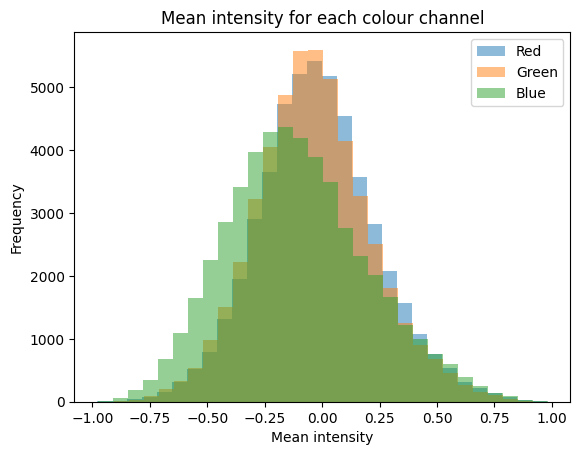

In [ ]:
#statitsical pixel analysis for each channel.
r_means, g_means, b_means = [], [], []

#loop through the dataset in batches
for images, _ in trainloader:
  #extracting channels RGB
    r_channel = images[:, 0, :, :]
    g_channel = images[:, 1, :, :]
    b_channel = images[:, 2, :, :]

    r_np = r_channel.numpy()
    g_np = g_channel.numpy()
    b_np = b_channel.numpy()
#then comoute means after we've numpy
    for i in range(r_np.shape[0]):
        r_means.append(np.mean(r_np[i]))
        g_means.append(np.mean(g_np[i]))
        b_means.append(np.mean(b_np[i]))

plt.hist(r_means, bins=30, alpha=0.5, label='Red')
plt.hist(g_means, bins=30, alpha=0.5, label='Green')
plt.hist(b_means, bins=30, alpha=0.5, label='Blue')
plt.legend()
plt.title("Mean intensity for each colour channel")
plt.xlabel("Mean intensity")
plt.ylabel("Frequency")
plt.show()


The above plot shows that each of the colours are centred around 0, suggesting similar colour distributions for each image. They each approximate to a bell curve meaning our dataset is well balanced and diverse in terms of colours.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#loading dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=False)

#we take one big batch of all training data
images, labels = next(iter(trainloader))

#then flatten images and shape
X = images.view(images.shape[0], -1).numpy()
labels = labels.numpy()
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

#now we plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA Projection of CIFAR-10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



The PCA (Principal component analysis) shows us that some variation was captured by the principal components, since there is some structure in the points when projected along the two principal component axis. The points belonging to the same class are close to each other, and the points or images that are very different are further away from each other.

In [ ]:
import torch
from scipy.stats import entropy
def image_entropy(img):
    img = img.squeeze()
    entropies = []
    for c in range(3):
        channel = img[c].flatten()
        hist = torch.histc(channel, bins=256).cpu().numpy()
        hist = hist / hist.sum()
        entropies.append(entropy(hist + 1e-8))
    return sum(entropies) / 3
entropies = []
for img, _ in trainloader:
    entropies.append(image_entropy(img))
    #calc average
avg_entropy = sum(entropies) / len(entropies)
print(f"Average entropy for CIFAR-10: {avg_entropy:.4f}")



KeyboardInterrupt: 

Entropy is a measure of how 'complicated' our images are. In real world ettings, we expect our data to have a high entropy as there are a range of different colours and shapes.


### Food 101

The CIFAR-10 is an idealised dataset where images are trnsformed to make them better suited to image classification. However, this is not reflective of real world scenarios sp we decided to focus on a more complax dataset.

The Food 101 dataset is a large scale dataset composed of realistic photos taken of different dishes. The data set was compiled by (@bossard14) who used images from 'foodspotting.com', a site that allows users to take images of what they are eating, annotate place and type of food, and upload the information online, resulting in this open source dataset.
The creators (@bossard14) created this with the aim of using image clasification with different dishes.

Food typically does not exhibit any distinctive spatial layout, unlike images in the CIFAR-10 dataset where an image with a plane often follows expected visual compositions of the sky in the background.
The images themselves are taken from different angles, different lightings, viewpoints and background context.
For this reason we felt this dataset reflected the complexities of real life scenarios.

This dataset consists of 101 food categories, with 101, 000 images. For each class, 250 manually cleaned test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

This dataset demonstrates a more realistic progression beyond CIFAR-10, allowing us to investigate deeper architectural choices, such as ResNet-18 and ViTs, before comparing model performance under imperfect, real-world conditions.

The data is split in the following way:
- Train: 75,750
- Test: 25,250

Below we import the dataset to get an overview :



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#loading Food-101 dataset
food_root = "data"
train_dataset = datasets.Food101(root=food_root, split="train", download=True)
test_dataset  = datasets.Food101(root=food_root, split="test",  download=True)

print(f"Full train size: {len(train_dataset)}, test size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

100%|██████████| 5.00G/5.00G [03:57<00:00, 21.0MB/s]


Full train size: 75750, test size: 25250
Number of classes: 101


Note: The original resolution is 256x256 but due to our limited GPU resources, we reduced to 64x64 to train our models effectively.

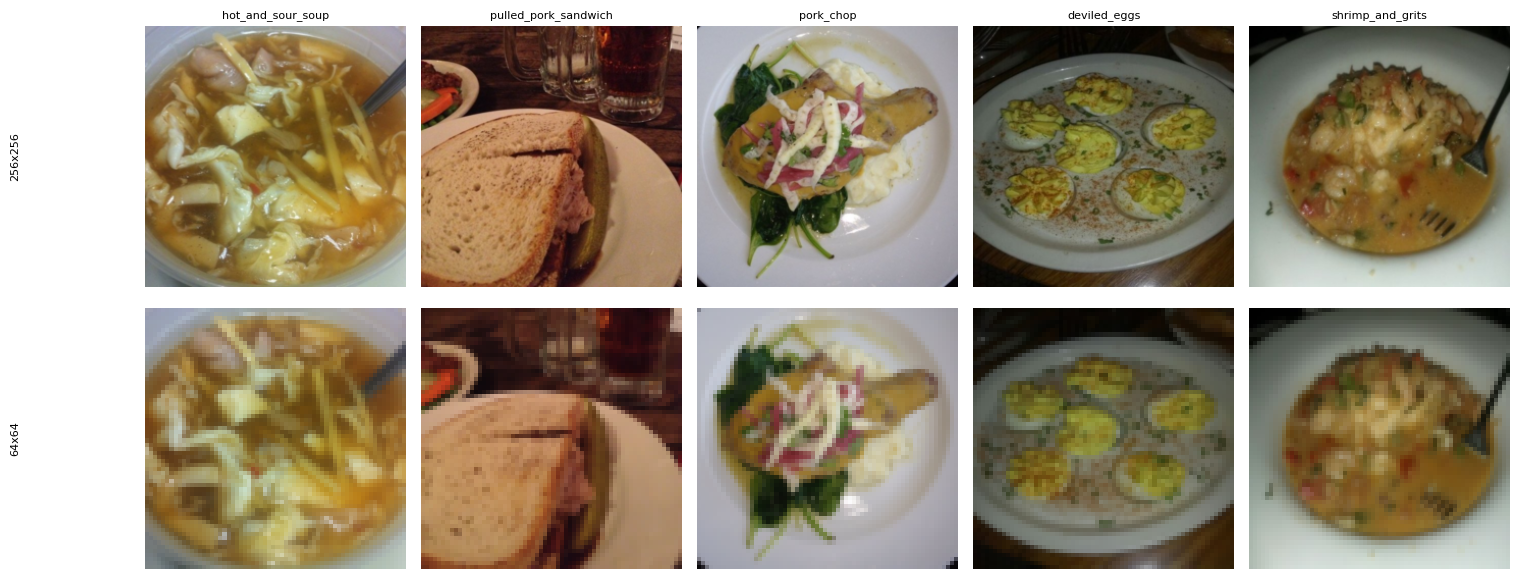

In [ ]:
subset_train_idx = random.sample(range(len(train_dataset)), 5)  # pick 5 random images
train_subset = Subset(train_dataset, subset_train_idx)

#we transform to 64x64 from the original 256
resolutions = [256, 64]
transforms_dict = {r: transforms.Compose([transforms.Resize((r,r)), transforms.ToTensor()]) for r in resolutions}
def plot_same_images_with_labels(dataset, resolutions):
    n = len(dataset)  # number of images in subset
    fig, axs = plt.subplots(len(resolutions), n, figsize=(n*3, len(resolutions)*3))

    for j in range(n):
        img, label_idx = dataset[j]
        label = dataset.dataset.classes[label_idx]#to get the class name
        for i, r in enumerate(resolutions):
            img_r = transforms_dict[r](img) # resizing
            img_np = img_r.permute(1,2,0).numpy()
            axs[i,j].imshow(img_np)
            axs[i,j].axis('off')

            if i == 0:
                axs[i,j].set_title(f"{label}", fontsize=8)
            if j == 0:
                axs[i,j].text(-0.5, 0.5, f"{r}x{r}", rotation=90, fontsize=8, va='center', ha='center', transform=axs[i,j].transAxes)
    plt.tight_layout()
    plt.show()

plot_same_images_with_labels(train_subset, resolutions)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#preparing our test and train
#making 64x64
transform_food101_64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
train_dataset_food101 = datasets.Food101(
    root=food_root,
    split="train",
    transform=transform_food101_64,
    download=False
)

test_dataset_food101 = datasets.Food101(
    root=food_root,
    split="test",
    transform=transform_food101_64,
    download=False
)
#training
train_loader_food101 = DataLoader(
    train_dataset_food101,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader_food101 = DataLoader(
    test_dataset_food101,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

print(f"Food-101 train samples: {len(train_dataset_food101)}")
print(f"Food-101 test  samples: {len(test_dataset_food101)}")
print(f"Number of classes: {len(train_dataset_food101.classes)}")



Food-101 train samples: 75750
Food-101 test  samples: 25250
Number of classes: 101


We can see that reducing the resolution in this way makes the images much harder to identify, but due to limitations in time constraints and GPUs for training, we had to reduce to 64x64 to be able to train our models.

# EDA Food 101
Now for some EDA on food 101:

In [ ]:
#mean pixels per channel
means, stds = [], []
for img, _ in train_subset:
    img_t = resize_64(img).unsqueeze(0)
    means.append(img_t.mean(dim=[2,3]).flatten())
    stds.append(img_t.std(dim=[2,3]).flatten())
means = torch.stack(means).mean(0)
stds = torch.stack(stds).mean(0)
print("Channel Means:", means)
print("Channel Stds:", stds)


Channel Means: tensor([0.5032, 0.4396, 0.3294])
Channel Stds: tensor([0.1645, 0.1722, 0.1848])


Unlike the CIFAR-10 dataset, we get bigger mean differences between RGB colour channels, suggesting that there is a greater dominance of certain colours preseent in some images.

In [ ]:
from scipy.stats import entropy

def image_entropy(img):
    hist = torch.histc(img, bins=256).cpu().numpy()
    return entropy(hist + 1e-8)

entropies = []
for img, _ in train_subset:
    entropies.append(image_entropy(resize_64(img)))
print("Avg entropy:", sum(entropies)/len(entropies))


As we expect, we have a higher entropy for food 101 data s there is more variety and randomisation within the image, compared to CIFAR10.

### Literature review

After reviewing (cite ResNet), we concluded that...

## Report

Discuss: appropriate strategy to learn about the computational per-
formance of the models- optimizing and comparing robustness?


Throughout our project we will explore the following:
- Optimization using CIFAR-10, looking at the following:
    - Number of convolutional layers and their impact on model performance
    - Learning rates
    - Optimizers
    - Kernels
    - Max_pool
    - Activation functions
    - Padding
    - And other hyperparameters

-  Creating ResNet18 from Scratch Using PyTorch and comparing to the plain model (cite)
Discuss: Why ResNet?? Why 18 layers ?
Using optimization we found from CIFAR-10


- Creating Transformer model (VIT)
Discuss: Why VIT?


- Using adversarial attack to test model robustness
Using a seperate test set and apply trnsforms such as noise, rotation etc to reflect a real-world scenario.
So here we are applying our models by testing on this set.


Question: Do we reduce the dataset?


## Optimization using CIFAR-10




Extension: visualising the effct of convolutional layers ?
image explanation of the kernel: https://arxiv.org/pdf/1311.2901

looking at the following:
  - Number of convolutional layers and their impact on model performance
  - Learning rates
  - Optimizers
  - Kernels
  - Max_pool
  - Activation functions
  - Padding
  - And other hyperparameters


Fine tuning? Discuss

## ResNet- 18
ResNet 18 is a pretrained model...
It  uses 18 convolutional layers.
After reading (cite), ...


Transfer learning ? - discuss

Kat use this video - https://www.youtube.com/watch?v=DkNIBBBvcPs

Discuss this paper to justify choice of layers and resnet : ResNet architecture: https://arxiv.org/pdf/1512.03385

ResNet-18 architecture

Why are we exploring this?

In this section we adopt the ResNet‑18 architecture for image classification because it provides a strong balance between depth, performance, and computational efficiency. We start by training a plain convolutional network with 18 layers, then incorporate residual connections to form the full ResNet‑18. This allows us to study the impact of residual learning while keeping the network depth moderate.

Why 18? ResNet‑18 is a moderately deep network, which is deep enough to extract meaningful hierarchical features but not so deep as to require excessive computation. This makes it suitable for this projetc given collab and gpu ..

## Baseline 18-layer CNN

We first implement a baseline convolutional neural network with 18 layers without residual connections.

We resize all the images to 64×64 pixels before training to make training faster and use less GPU memory. Smaller images need fewer calculations because the number of operations in convolution layers grows roughly with the height × width of the image. For example, reducing from 256×256 to 64×64 cuts the number of operations in the first layer by about 16×. This also produces smaller feature maps, so we can use a reasonable batch size without running out of memory. Overall, this keeps training time manageable, which is important because our GPU and time are limited. Although, we do lose some detail, 64×64 should be enough for the network to learn useful features in Food-101.

In [ ]:
# Transform to 64x64px
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset64 = datasets.Food101(root="data", split="train", download=False, transform=transform)
test_dataset64  = datasets.Food101(root="data", split="test",  download=False, transform=transform)

train_loader64 = DataLoader(train_dataset64, batch_size=64, shuffle=True)
test_loader64  = DataLoader(test_dataset64, batch_size=64, shuffle=False)

We use a plain 18 layer CNN as our baseline model for the Food 101 dataset with 101 classes. The network has eight convolutional blocks followed by global average pooling and a fully connected layer. Each block contains a convolutional layer, batch normalization, and a ReLU activation. We use this structure because it provides enough depth to learn meaningful features while still being simple and efficient to train.

All convolutional layers use 3×3 kernels. We choose 3×3 because small kernels capture local patterns effectively and, when stacked, give a large effective receptive field without requiring many parameters. This improves efficiency and still allows the network to learn detailed textures and shapes. We increase the number of channels from 64 in early layers to 512 in deeper layers so the network can learn more abstract features as depth increases.

Some convolutional layers use a stride of 2 to downsample the spatial resolution of the feature maps. This reduces computation and helps the network compress information into channel depth. For stride 1 layers, we apply padding of 1 so that the spatial dimensions remain unchanged.

Batch normalization follows each convolution to stabilise the activation distributions and make training more reliable. After batch normalization, we apply a ReLU activation to introduce non linearity, which allows the network to learn complex decision boundaries.

After the final convolutional block, we apply global average pooling to reduce each feature map to a single value. This produces a compact representation and prevents the final stage of the model from having too many parameters. The resulting 512 dimensional vector is then passed into a fully connected layer that outputs the 101 class logits.

During training, we use mini batches rather than single images. A batch size such as 32 or 64 provides stable gradient estimates and works well with batch normalization. This completes the baseline architecture we use for the Food 101 classification task.

In [ ]:
# Defining our own CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plain 18-layer CNN (like ResNet18, no residuals)
class Plain18(nn.Module):
    def __init__(self, num_classes=101):  # for Food-101
        super().__init__()

        # Each block = conv + batchnorm + ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Plain18(num_classes=101).to(device)
print(model)

## Training loop
We use a standard training setup with an optimizer, a loss function, a batch size, and a set number of epochs. These values are chosen because they work well given our memory and time limits. The idea is to have something that trains reliably without using too much GPU memory or taking too long. This gives us a good starting point, and of course, we could try other values or setups. We actually explored different options in more detail in the other section.

The training loop works the usual way. We pass the images through the network, compute the loss, backpropagate to get the gradients, and then update the model parameters. While training, we keep track of the loss and accuracy for both training and test sets, and we also record the time per epoch. Having all these metrics helps us see how well the model is learning and also gives an idea of efficiency, which is useful when thinking about scaling up experiments.

If we wanted to tune hyperparameters properly, we would set aside a validation set and test different choices like learning rate, batch size, or optimizer type. This would help us find a better configuration without touching the test set. Since hyperparameter tuning can take a lot of time, we didn’t do a full search here. But the other section explains the approaches we could use if we wanted to explore it more.

In [ ]:
# Training loop    -  what optimiser? What learing rate, batch size etc.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

model = Plain18(num_classes=101).to(device)
batch_size = 64

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Metrics lists
Train_loss_plain18 = []
Train_acc_plain18 = []
Test_loss_plain18 = []
Test_acc_plain18 = []
Epoch_time_plain18 = []

# Training loop
epochs = 3  # quick testing
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    model.train()
    running_loss, running_correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_plain18.append(epoch_train_loss)
    Train_acc_plain18.append(epoch_train_acc)

    # Evaluation
    model.eval()
    test_loss, correct, total_test = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_plain18.append(epoch_test_loss)
    Test_acc_plain18.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_plain18.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")

In [ ]:
# Plot loss, accuracy and time per epoch
plt.figure(figsize=(18,5))


# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_plain18, marker='o', label="Train Loss Plain-18")
plt.plot(Test_loss_plain18, marker='s', label="Test Loss Plain-18")
plt.title("Plain-18 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()


# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_plain18], marker='o', label="Train Acc Plain-18")
plt.plot([a*100 for a in Test_acc_plain18], marker='s', label="Test Acc Plain-18")
plt.title("Plain-18 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()


# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_plain18, marker='o', label="Epoch Time Plain-18")
plt.title("Plain-18 Epoch Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

For moderate depths, such as our 18-layer baseline, adding layers generally improves performance because the network can learn more complex and abstract features. However, as networks become very deep, simply stacking more layers does not always help and can even make training harder. This is due to degradation, which occurs when gradients vanish or explode during backpropagation. When gradients vanish, early layers receive very small updates and learn very slowly, and when gradients explode, updates become unstable, which can cause training to fail. This shows that while deeper networks have more capacity, there are practical limits to how far we can increase depth without careful design or training strategies.

## Residual 18-layer CNN (ResNet-18)
We train the ResNet18 model using the same setup as the plain 18-layer CNN, but the difference is in the architecture. We introduce residual blocks, where each block has two convolutional layers and a shortcut connection that allows the input to bypass the convolutions and be added to the output. This makes training more stable because the shortcut provides a direct path for gradients to flow backward during training. Even if the gradients through the convolutional layers become very small or very large, the shortcut ensures that the gradient signal reaching earlier layers is preserved. This reduces the risk of vanishing or exploding gradients and allows the network to take full advantage of the added depth, letting it learn more complex features without training degradation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Residual Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet18 - residual
class ResNet18(nn.Module):
    def __init__(self, num_classes=101):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out

# Initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet18_model = ResNet18(num_classes=101).to(device)

# Training loop variables
batch_size = 64
epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=1e-3)

Train_loss_res18 = []
Train_acc_res18 = []
Test_loss_res18 = []
Test_acc_res18 = []
Epoch_time_res18 = []

# Training loop
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    resnet18_model.train()
    running_loss, running_correct, total = 0,0,0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_res18.append(epoch_train_loss)
    Train_acc_res18.append(epoch_train_acc)

    # Evaluation
    resnet18_model.eval()
    test_loss, correct, total_test = 0,0,0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_res18.append(epoch_test_loss)
    Test_acc_res18.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_res18.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")


In [ ]:
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_res18, marker='o', label="Train Loss Res-18")
plt.plot(Test_loss_res18, marker='s', label="Test Loss Res-18")
plt.title("ResNet-18 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_res18], marker='o', label="Train Acc Res-18")
plt.plot([a*100 for a in Test_acc_res18], marker='s', label="Test Acc Res-18")
plt.title("ResNet-18 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()


# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_res18, marker='o', label="Epoch Time Res-18")
plt.title("ResNet-18 Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Pretrained ResNet 18
Load ResNet-18 pretrained on ImageNet. Fine-tune on your dataset

Load the ResNet-18 model pretrained on ImageNet.

Replace the final fully-connected layer to match your dataset's number of classes.

Optionally, freeze some early layers if you want to fine-tune only higher layers.

Train using your dataset.

Pre-trained models are neural networks that have already been trained on large datasets for a general task such as image classification. Using a pre-trained model allows us to leverage the features it has already learned, like edges, textures, and higher-level patterns, rather than training a network from scratch. This can save a lot of time and computational resources, and it often improves performance, especially when the dataset for the target task is smaller or limited.

However, pre-trained models are not always perfectly suited to every task. If the new dataset is very different from the dataset used for pre-training, the learned features may not fully capture the relevant patterns, which can limit performance. Additionally, large pre-trained networks can be computationally demanding and require significant memory, which may be a practical limitation depending on available hardware.

In this work, we focus on ResNet-18 as our pre-trained model. ResNet-18 is a residual network trained on ImageNet, a large dataset containing over a million images across 1,000 categories of everyday objects, animals, and scenes. The model has learned general visual features that can be applied to many tasks, including food classification. In this section, we explore how to adapt ResNet-18 for the Food-101 dataset using feature extraction and fine-tuning, two common approaches in transfer learning that allow the model to leverage its pre-trained knowledge while adapting to a new task.



## Feature extraction
For this experiment, we keep the same training setup and parameters as before, including batch size, epochs, loss, and optimizer. The main change is that we freeze all pre-trained ResNet-18 layers and only train the final fully connected layer, which is adjusted to output 101 classes for Food-101. This reduces the number of trainable parameters, making training faster and more stable, while still taking advantage of the rich feature representations learned from ImageNet. Using the same setup allows a direct comparison with our other models and demonstrates the benefits of transfer learning.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Parameters
num_classes = 101
batch_size = 64
epochs = 3
learning_rate = 1e-4

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Load Food-101 dataset
train_dataset = datasets.Food101(root="./data", split="train", download=True, transform=train_transform)
test_dataset = datasets.Food101(root="./data", split="test", download=True, transform=test_transform)

train_loader64 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader64 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet-18
pretrained_resnet18 = models.resnet18(pretrained=True)

# Freeze all layers for feature extraction
for param in pretrained_resnet18.parameters():
    param.requires_grad = False

# Replace final layer
pretrained_resnet18.fc = nn.Linear(pretrained_resnet18.fc.in_features, num_classes)
pretrained_resnet18 = pretrained_resnet18.to(device)

# Loss and optimizer (only train final layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet18.fc.parameters(), lr=learning_rate)

# Metrics lists
Train_loss_resnet18 = []
Train_acc_resnet18 = []
Test_loss_resnet18 = []
Test_acc_resnet18 = []
Epoch_time_resnet18 = []

# Training loop
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    pretrained_resnet18.train()
    running_loss, running_correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_resnet18.append(epoch_train_loss)
    Train_acc_resnet18.append(epoch_train_acc)

    # Evaluation
    pretrained_resnet18.eval()
    test_loss, correct, total_test = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_resnet18(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_resnet18.append(epoch_test_loss)
    Test_acc_resnet18.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_resnet18.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")


In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(Train_loss_resnet18, label='Train Loss')
plt.plot(Test_loss_resnet18, label='Test Loss')
plt.title('ResNet-18 Feature Extraction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot([a*100 for a in Train_acc_resnet18], label='Train Accuracy')
plt.plot([a*100 for a in Test_acc_resnet18], label='Test Accuracy')
plt.title('ResNet-18 Feature Extraction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Fine tuning
Fine-tuning is another way to use a pre-trained model, like ResNet-18 trained on ImageNet, where we allow more of its layers to be updated when training on our dataset. Unlike feature extraction, where we only train the final classifier, fine-tuning lets the network adjust its pre-trained weights to better match the new data. This can help the model do better, especially if the target dataset is a bit different from the one used for pre-training.

The lower layers of a convolutional network usually capture general features like edges, textures, and shapes, which are useful across tasks, while the higher layers focus on patterns specific to the original task. By fine-tuning, we allow the weights in some or all layers to change, so the network can adapt to the new task. The downside is that this requires more computation, takes longer to train, and often needs a lower learning rate so that we don’t overwrite the useful pre-trained weights too quickly.

For our project, because of time and resources, we will only update the weights in the deeper layers of ResNet-18 while keeping the early layers frozen. This lets the network learn task-specific features without changing everything, keeping the general features intact. In this section, we will explore partial fine-tuning on the Food-101 dataset and compare it with feature extraction to see how adjusting the pre-trained weights affects results.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Parameters
num_classes = 101
batch_size = 64
epochs = 8
learning_rate = 1e-4

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Load Food-101 dataset
train_dataset = datasets.Food101(root="./data", split="train", download=True, transform=train_transform)
test_dataset = datasets.Food101(root="./data", split="test", download=True, transform=test_transform)

train_loader64 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader64 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet-18
resnet18_ft = models.resnet18(pretrained=True)

# Freeze early layers (for example, layers 1 and 2)
for name, param in resnet18_ft.named_parameters():
    if "layer1" in name or "layer2" in name:
        param.requires_grad = False

# Replace final layer
resnet18_ft.fc = nn.Linear(resnet18_ft.fc.in_features, num_classes)
resnet18_ft = resnet18_ft.to(device)

# Only optimize parameters that require gradients (deeper layers + classifier)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet18_ft.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Metrics lists
Train_loss_res18_ft = []
Train_acc_res18_ft = []
Test_loss_res18_ft = []
Test_acc_res18_ft = []
Epoch_time_res18_ft = []

# Training loop
total_start_time = time.time()
for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    resnet18_ft.train()
    running_loss, running_correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_res18_ft.append(epoch_train_loss)
    Train_acc_res18_ft.append(epoch_train_acc)

    # Evaluation
    resnet18_ft.eval()
    test_loss, correct, total_test = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_ft(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_res18_ft.append(epoch_test_loss)
    Test_acc_res18_ft.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_res18_ft.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")


In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), Train_loss_res18_ft, label="Train Loss")
plt.plot(range(1, epochs+1), Test_loss_res18_ft, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet-18 Partial Fine-Tuning Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), Train_acc_res18_ft, label="Train Accuracy")
plt.plot(range(1, epochs+1), Test_acc_res18_ft, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet-18 Partial Fine-Tuning Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Metrics
## Loss vs Accuracy

Loss measures how far off the model’s predictions are from the correct answers. In classification, cross-entropy loss is usually used. If $y_{i,c}$ is the true label for example $i$ and class $c$ (1 if correct, 0 otherwise), and $p_{i,c}$ is the predicted probability, the loss is:  

$$
L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})
$$

Smaller loss means the model is making predictions closer to the truth. For example, if the model predicts “cat” with 90% probability for an image that is actually a cat, the loss is low. If it predicts “dog” with 90% instead, the loss is high.  

Accuracy measures the fraction of predictions the model got exactly right. If $\hat{y}_i$ is the predicted class of example $i$, accuracy is:  

$$
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\hat{y}_i = y_i)
$$  

where $\mathbf{1}(\cdot)$ is 1 if the prediction is correct, 0 if not. Accuracy does not care how wrong the wrong predictions were.  

## Train vs Test Metrics
Train metrics, including loss and accuracy, show how well the model is learning from the data it is trained on. Low train loss and high train accuracy indicate that the model fits the training data well and is capturing the patterns present in that data.  

Test metrics, computed on unseen data, show how well the model generalises. They tell us whether the model can make accurate predictions on new examples it has never seen before.  

Comparing train and test metrics gives some insights about the model’s behavior. If test loss is higher and test accuracy is lower than train, the model is propably overfitting as it has memorized details of the training data that do not apply to new data. On the other hand, if test metrics are better than train metrics, it may indicate underfitting, or that the training data is noisier or more difficult than the test set.  



In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 101  # Food-101

# Load pretrained ResNet-18
pretrained_model = models.resnet18(pretrained=True)

# Replace final layer
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Move to device
pretrained_model = pretrained_model.to(device)

# (Optional) Freeze early layers if desired
# for name, param in pretrained_model.named_parameters():
#     if "layer4" not in name and "fc" not in name:
#         param.requires_grad = False

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=1e-4)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 3
batch_size = 64

# Load pretrained ResNet-18
pretrained_resnet18 = models.resnet18(pretrained=True)
pretrained_resnet18.fc = nn.Linear(pretrained_resnet18.fc.in_features, num_classes)
pretrained_resnet18 = pretrained_resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet18.parameters(), lr=1e-4)  # lower LR for pretrained

# Metrics lists
Train_loss_resnet18 = []
Train_acc_resnet18 = []
Test_loss_resnet18 = []
Test_acc_resnet18 = []
Epoch_time_resnet18 = []

# Training loop
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    pretrained_resnet18.train()
    running_loss, running_correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_resnet18.append(epoch_train_loss)
    Train_acc_resnet18.append(epoch_train_acc)

    # Evaluation
    pretrained_resnet18.eval()
    test_loss, correct, total_test = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_resnet18(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_resnet18.append(epoch_test_loss)
    Test_acc_resnet18.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_resnet18.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")



In [ ]:
# Plotting Loss, Accuracy, Time
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_resnet18, marker='o', label="Train Loss ResNet-18")
plt.plot(Test_loss_resnet18, marker='s', label="Test Loss ResNet-18")
plt.title("ResNet-18 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_resnet18], marker='o', label="Train Acc ResNet-18")
plt.plot([a*100 for a in Test_acc_resnet18], marker='s', label="Test Acc ResNet-18")
plt.title("ResNet-18 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_resnet18, marker='o', color='purple', label="Epoch Time (s)")
plt.title("ResNet-18 Epoch Time")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Comparison of different models

In [ ]:
plt.figure(figsize=(18,5))


# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_plain18, marker='o', label="Train Loss Plain-18")
plt.plot(Test_loss_plain18, marker='s', label="Test Loss Plain-18")
plt.plot(Train_loss_res18, marker='^', label="Train Loss Residual-18")
plt.plot(Test_loss_res18, marker='v', label="Test Loss Residual-18")
plt.plot(Train_loss_resnet18, marker='D', label="Train Loss Pretrained-18")
plt.plot(Test_loss_resnet18, marker='X', label="Test Loss Pretrained-18")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend(fontsize=8)

# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_plain18], marker='o', label="Train Acc Plain-18")
plt.plot([a*100 for a in Test_acc_plain18], marker='s', label="Test Acc Plain-18")
plt.plot([a*100 for a in Train_acc_res18], marker='^', label="Train Acc Residual-18")
plt.plot([a*100 for a in Test_acc_res18], marker='v', label="Test Acc Residual-18")
plt.plot([a*100 for a in Train_acc_resnet18], marker='D', label="Train Acc Pretrained-18")
plt.plot([a*100 for a in Test_acc_resnet18], marker='X', label="Test Acc Pretrained-18")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend(fontsize=8)

# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_plain18, marker='o', label="Plain-18")
plt.plot(Epoch_time_res18, marker='^', label="Residual-18")
plt.plot(Epoch_time_resnet18, marker='D', label="Pretrained-18")
plt.title("Epoch Time")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

## VIT Transformer
A 'state of the art' ....

Vision transformers and ViT architecture: https://arxiv.org/pdf/2010.11929

## Training from scratch

## Transfer learning

## Testing robustness
We compare robustness of our models by transforming our images and seeing how this affects our results.
Comparing robustness:

After reading https://ieeexplore.ieee.org/document/11098661, we discovered a number of ways we could adjust our iages to challenge the model.
We've modified the test set in the following way:

- Adding noise
- Random rotations
- Brightness
- Defocus
- Pixelate
- Fog attack
- Frost attack



In [ ]:
#libraries just for robustness
import torch
import numpy as np
import cv2
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

We add blurs and noise etc at different severities, this way we get a very clear visualisation of how this affects all of the models.

In [ ]:
SEVERITY_LEVELS = [1, 2, 3, 4, 5]

import cv2
import numpy as np
import torch
import torch.nn.functional as F

#adding noise
def add_noise(images, severity):
    noise_level = 0.05 * severity
    noise = torch.randn_like(images) * noise_level
    return torch.clamp(images + noise, -1, 1).float()

#brightness
def change_brightness(images, severity):
    factor = 1 - 0.15 * severity
    return torch.clamp(images * factor, -1, 1).float()

#gaussian blur
def defocus_blur(images, severity):
    kernel_size = 2 * severity + 1
    blurred = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()
        npimg_blur = cv2.GaussianBlur(npimg, (kernel_size, kernel_size), 0)
        blurred.append(torch.tensor(npimg_blur).permute(2,0,1))
    return torch.stack(blurred).clamp(-1,1).float()

#pixelate
def pixelate(images, severity):
    scale_down = 2 + severity * 2
    pixelated = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()
        h, w = npimg.shape[:2]
        small = cv2.resize(npimg, (h//scale_down, w//scale_down), interpolation=cv2.INTER_LINEAR)
        big = cv2.resize(small, (h, w), interpolation=cv2.INTER_NEAREST)
        pixelated.append(torch.tensor(big).permute(2,0,1))
    return torch.stack(pixelated).clamp(-1,1).float()

#fog
def add_fog(images, severity):
    fog_strength = 0.1 * severity
    foggy = []
    for img in images:
        npimg = img.cpu().numpy()
        h, w = npimg.shape[1], npimg.shape[2]
        fog = np.random.normal(0.5, 0.2, (3, h, w))
        foggy.append(torch.tensor(npimg + fog_strength * fog))
    return torch.stack(foggy).clamp(-1,1).float()

#frost
def frost(images, severity):
    frost_strength = 0.15 * severity
    frosted = []
    for img in images:
        npimg = img.cpu().numpy()
        frost_noise = np.random.normal(0.7, 0.3, npimg.shape)
        frosted_img = npimg * (1 - frost_strength) + frost_strength * frost_noise
        frosted.append(torch.tensor(frosted_img))
    return torch.stack(frosted).clamp(-1,1).float()


Now we apply these attacks to our CIFAR-10 dataset, using Severity=3 from the 1-5 scale for visualisation.

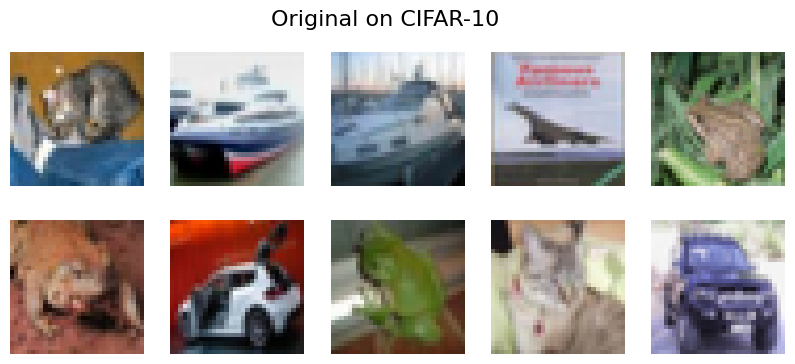

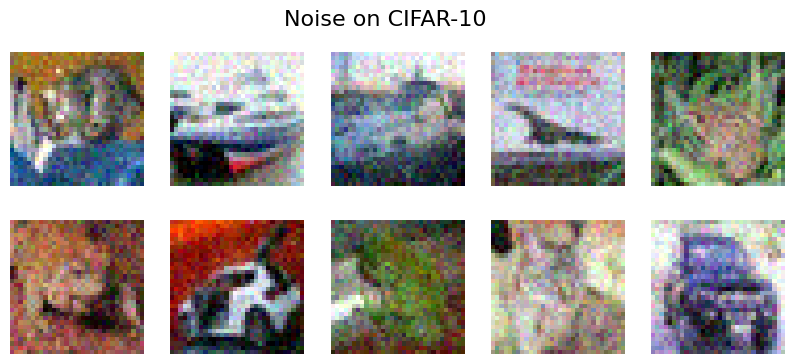

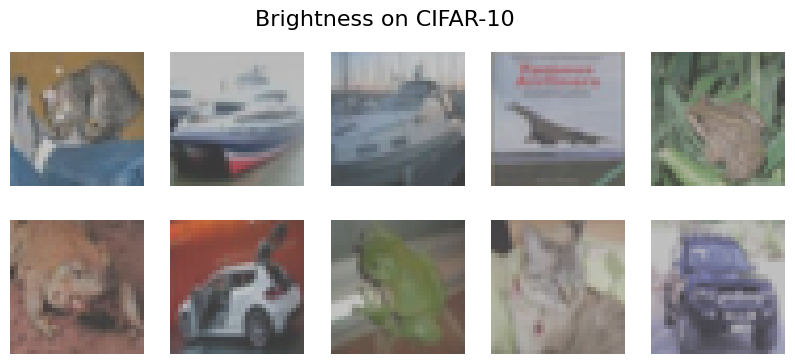

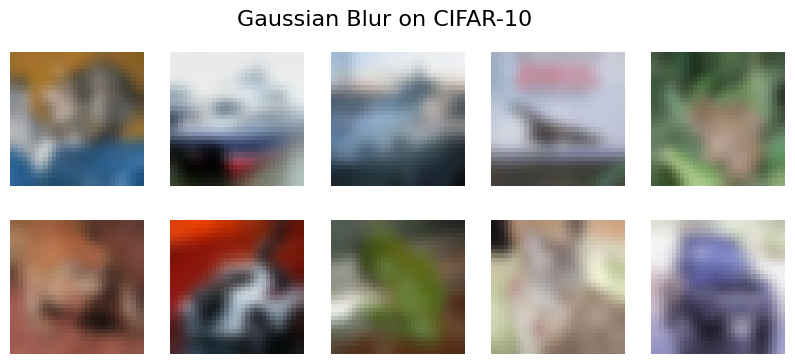

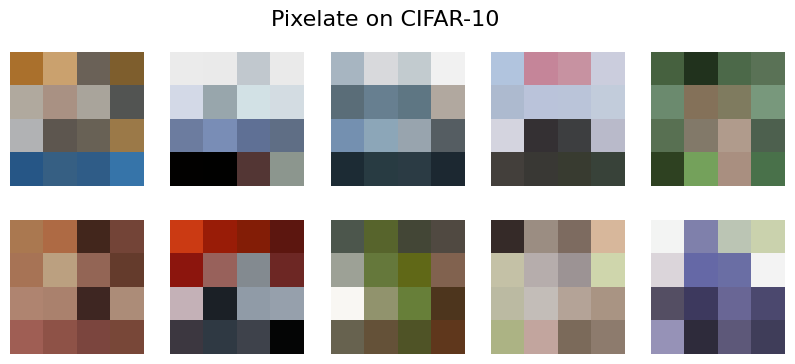

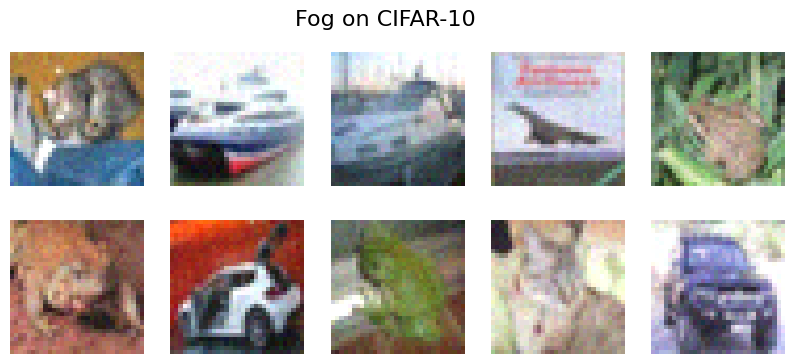

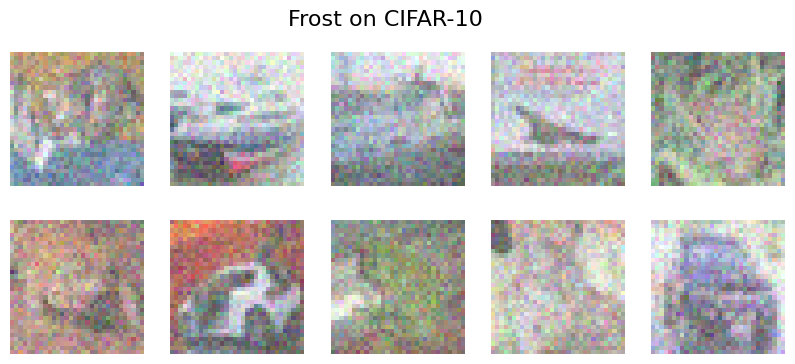

In [ ]:
import matplotlib.pyplot as plt

SEVERITY = 3 #we have severity ranging 1-5, so choose the mid severity on these

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images[:10]  #show 10 images

attacks = {
    "Original": images,
    "Noise": add_noise(images, SEVERITY),
    "Brightness": change_brightness(images, SEVERITY),
    "Gaussian Blur": defocus_blur(images, SEVERITY),
    "Pixelate": pixelate(images, SEVERITY),
    "Fog": add_fog(images, SEVERITY),
    "Frost": frost(images, SEVERITY)
}

for name, attacked_imgs in attacks.items():
    plt.figure(figsize=(10, 4))
    for i in range(10):
        img = attacked_imgs[i] / 2 + 0.5  #unnormalise
        npimg = img.cpu().numpy()
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    plt.suptitle(f'{name} on CIFAR-10', size=16)
    plt.show()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
#we define a function that we can use to evaluate each of these 'scenarios' on our models
def evaluate_attack(model, attack_fn, testloader):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for severity in SEVERITY_LEVELS:
            correct = total = 0
            for images, labels in testloader:
                images = attack_fn(images, severity)
                outputs = model(images.to(device))
                _, preds = torch.max(outputs, 1)
                correct += (preds.cpu() == labels).sum().item()
                total += labels.size(0)
            accuracies.append(100 * correct / total)
    return accuracies

To load the models in to colab, we downloaded them to google drive and used this approach- there must be a better way to do this?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#this allows us to load within colab

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn

file_path_resnet = "/content/drive/MyDrive/Resnet18.py" # already uploaded

with open(file_path_resnet, "r") as f:
    resnet_code = f.read()

exec(resnet_code)  # defines ResNet18_CIFAR10 in memory
print("ResNet18 def loaded")

ResNet18_acc_PATH  = "/content/drive/MyDrive/resnet18_cifar10_best_acc.pth"
ResNet18_loss_PATH = "/content/drive/MyDrive/resnet18_cifar10_best_loss.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_res_acc  = ResNet18(num_classes=10).to(device)
model_res_loss = ResNet18(num_classes=10).to(device)

# Load weights
state_res_acc  = torch.load(ResNet18_acc_PATH,  map_location=device)
state_res_loss = torch.load(ResNet18_loss_PATH, map_location=device)

model_res_acc.load_state_dict(state_res_acc)
model_res_loss.load_state_dict(state_res_loss)

model_res_acc.eval()
model_res_loss.eval()

print("ResNet18 best-acc and best-loss models loaded")



ResNet18 definition loaded successfully!
ResNet18 best-acc and best-loss models loaded successfully! 🚀


In [ ]:
import torch
import torch.nn as nn

file_path_vit = "/content/drive/MyDrive/SL_Vit.py"   # already uploaded here

with open(file_path_vit, "r") as f:
    vit_code = f.read()

exec(vit_code)   # defines ViT in memory
print("SLViT architecture loaded successfully!")

Vit_acc_PATH  = "/content/drive/MyDrive/slvit_cifar10_best_acc.pth"
Vit_loss_PATH = "/content/drive/MyDrive/slvit_cifar10_best_loss.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vit_acc = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

model_vit_loss = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

# Load weights
state_vit_acc  = torch.load(Vit_acc_PATH,  map_location=device)
state_vit_loss = torch.load(Vit_loss_PATH, map_location=device)

model_vit_acc.load_state_dict(state_vit_acc)
model_vit_loss.load_state_dict(state_vit_loss)

model_vit_acc.eval()
model_vit_loss.eval()

print("SLViT best-ACC and best-LOSS models loaded")


SLViT architecture loaded successfully!
SLViT best-ACC and best-LOSS models loaded successfully! 🚀


In [ ]:
attack_results_Res_acc = {
    "Noise":       evaluate_attack(model_res_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_acc, frost, testloader),
}

attack_results_Res_loss = {
    "Noise":       evaluate_attack(model_res_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_loss, frost, testloader),
}


In [ ]:
attack_results_Vit_acc = {
    "Noise":       evaluate_attack(model_vit_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_acc, frost, testloader),
}


attack_results_Vit_loss = {
    "Noise":       evaluate_attack(model_vit_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_loss, frost, testloader),
}



<Figure size 640x480 with 0 Axes>

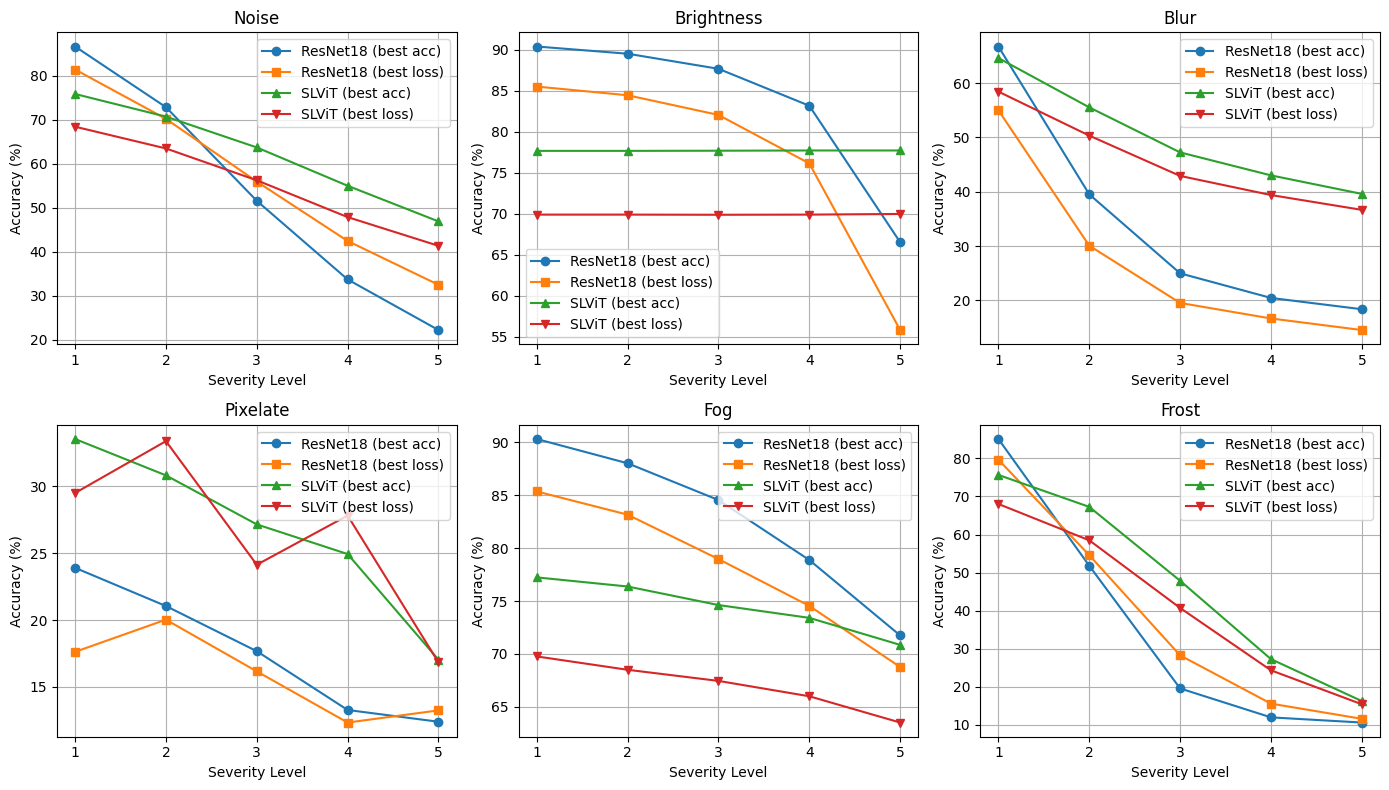

In [ ]:
import matplotlib.pyplot as plt
plt.suptitle("CIFAR-10 Robustness (comparing ResNet18 and SLViT)", fontsize=16, y=1.02)

attacks = list(attack_results_Res_acc.keys())
num_attacks = len(attacks)

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]

    # Get curves for each model
    acc_curve_res   = attack_results_Res_acc[attack_name]
    loss_curve_res  = attack_results_Res_loss[attack_name]
    acc_curve_vit   = attack_results_Vit_acc[attack_name]
    loss_curve_vit  = attack_results_Vit_loss[attack_name]

    # Plot
    ax.plot(SEVERITY_LEVELS, acc_curve_res,   marker='o', label='ResNet18 (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_res,  marker='s', label='ResNet18 (best loss)')
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,   marker='^', label='SLViT (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_vit,  marker='v', label='SLViT (best loss)')

    ax.set_title(attack_name)
    ax.set_xlabel("Severity Level")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)
    ax.legend()

# Hide unused axes if any remain
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



So now we've effectively created our modified test sets hat can be used to test the model's robustness on the CIFAR-10 dataset. The modifications and attack choices were chosen due to teh fact the mirror modifications that we might encounter in a real world scenario.

# Adversarial attack on Food 101
Despite the fact these images are collected from a real world scenario, hence already including varied brightnesses and blur, we enhance these to test the robustness of our models.

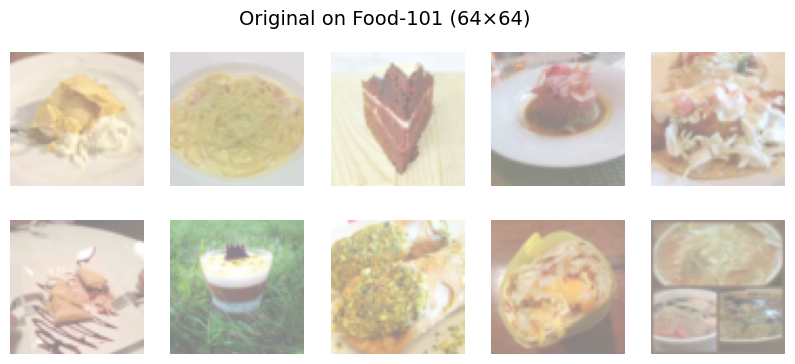

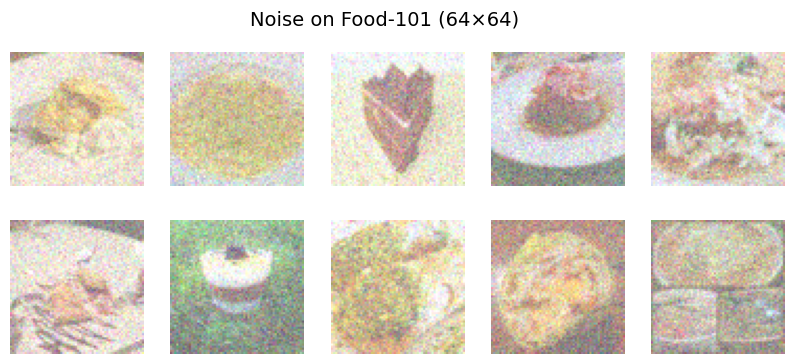

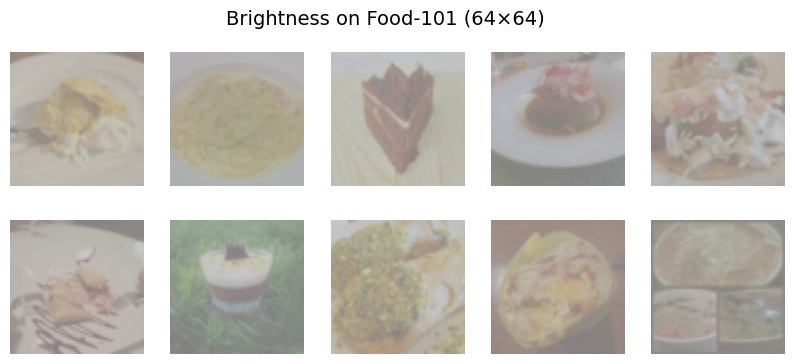

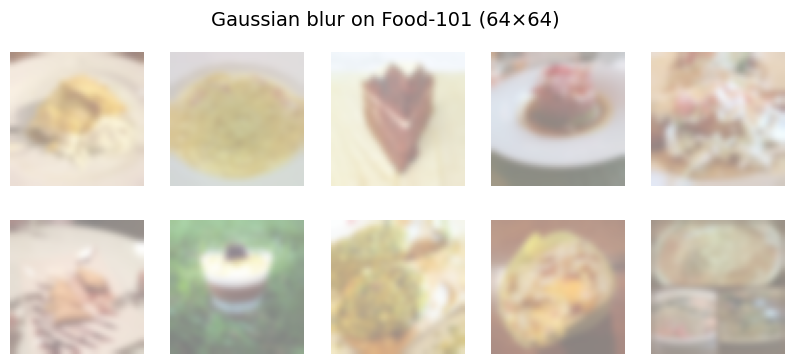

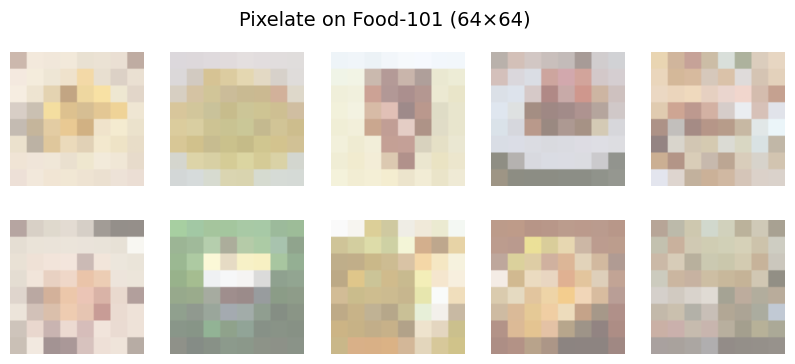

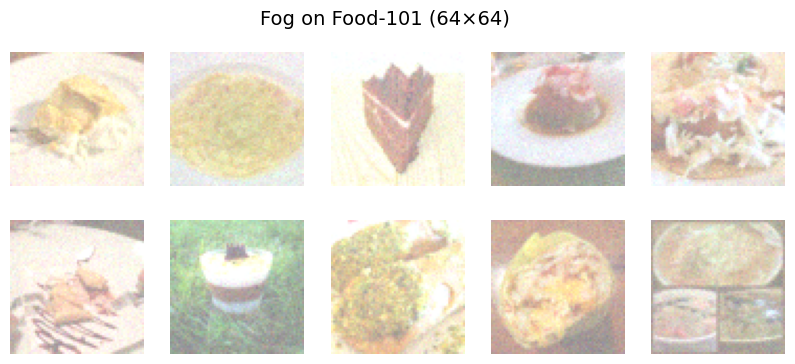

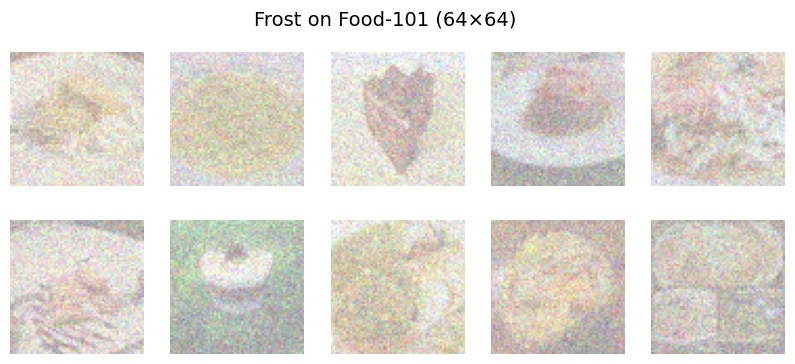

In [ ]:
tensor_images = []
labels_list  = []

for img, label in train_subset:
    tensor_images.append(img)
    labels_list.append(label)

images_64 = torch.stack(tensor_images)
labels_64 = torch.tensor(labels_list)

modifications = {
    "Original":    images_64,
    "Noise":       add_noise(images_64, severity=3),
    "Brightness":  change_brightness(images_64, severity=3),
    "Gaussian blur": defocus_blur(images_64, severity=3),
    "Pixelate":    pixelate(images_64, severity=3),
    "Fog":         add_fog(images_64, severity=3),
    "Frost":       frost(images_64, severity=3)
}

# 🎨 Visualisation
for name, attacked_imgs in modifications.items():
    plt.figure(figsize=(10, 4))
    for i in range(len(attacked_imgs)):
        img = attacked_imgs[i] / 2 + 0.5
        npimg = img.numpy().transpose(1, 2, 0)
        plt.subplot(2, 5, i + 1)
        plt.imshow(npimg)
        plt.axis('off')
    plt.suptitle(f'{name} on resized Food-101', size=14)
    plt.show()



Now we apply our neural networks to our adversarial attack datasets, the results can be seen in the visualisation below. But first we must load the models.





In [ ]:
import torch
import torch.nn as nn
file_path_resnet = "/content/drive/MyDrive/Resnet18.py"  # already uploaded

with open(file_path_resnet, "r") as f:
    resnet_code = f.read()

exec(resnet_code)   # defines ResNet18_CIFAR10 in memory
print("ResNet18 architecture loaded successfully!")

ResNet18_food_PATH = "/content/drive/MyDrive/resnet18_food101_best.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model
model_food_res = ResNet18(num_classes=101).to(device)

# Load state dict
state_food_res= torch.load(ResNet18_food_PATH, map_location=device)
model_food_res.load_state_dict(state_food_res)
model_food_res.eval()

print("ResNet18 Food-101 model loaded")



ResNet18 architecture loaded successfully!
ResNet18 Food-101 model loaded successfully! 🍔🚀


In [ ]:
import torch
import torch.nn as nn
file_path_vit = "/content/drive/MyDrive/SL_Vit.py"   # already uploaded

with open(file_path_vit, "r") as f:
    vit_code = f.read()

exec(vit_code)   # defines ViT in memory
print("SLViT architecture loaded successfully!")
Vit_food_PATH  = "/content/drive/MyDrive/slvit_food101_best.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_food_vit():
    return ViT(
        image_size = 64,
        patch_size = 8,
        num_classes = 101,
        dim = 256,
        depth = 6,
        heads = 8,
        mlp_dim = 512,
        dropout = 0.1,
        emb_dropout = 0.1
    )
model_vit_food = make_food_vit().to(device)
state_vit_food = torch.load(Vit_food_PATH, map_location=device)

model_vit_food.load_state_dict(state_vit_food)
model_vit_food.eval()

print("SLViT Food-101 BEST-ACC & BEST-LOSS loaded")


SLViT architecture loaded successfully!
SLViT Food-101 BEST-ACC & BEST-LOSS loaded successfully! 🧠🍜


In [ ]:
attack_results_Food101_ResNet_best = {
    "Noise":       evaluate_attack(model_food_res, add_noise, test_loader_food101),
    "Brightness":  evaluate_attack(model_food_res, change_brightness, test_loader_food101),
    "Blur":        evaluate_attack(model_food_res, defocus_blur, test_loader_food101),
    "Pixelate":    evaluate_attack(model_food_res, pixelate, test_loader_food101),
    "Fog":         evaluate_attack(model_food_res, add_fog, test_loader_food101),
    "Frost":       evaluate_attack(model_food_res, frost, test_loader_food101),
}


In [ ]:
attack_results_Food101_ViT_best = {
    "Noise":       evaluate_attack(model_vit_food, add_noise, test_loader_food101),
    "Brightness":  evaluate_attack(model_vit_food, change_brightness, test_loader_food101),
    "Blur":        evaluate_attack(model_vit_food, defocus_blur, test_loader_food101),
    "Pixelate":    evaluate_attack(model_vit_food, pixelate, test_loader_food101),
    "Fog":         evaluate_attack(model_vit_food, add_fog, test_loader_food101),
    "Frost":       evaluate_attack(model_vit_food, frost, test_loader_food101),
}



In [ ]:
import matplotlib.pyplot as plt

plt.suptitle("Food-101 Robustness (ResNet18 vs SLViT)", fontsize=16, y=1.02)

attacks = list(attack_results_Food101_ResNet_best.keys())
num_attacks = len(attacks)

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]

    # Get severity curves for both models
    acc_curve_resnet = attack_results_Food101_ResNet_best[attack_name]
    acc_curve_vit    = attack_results_Food101_ViT_best[attack_name]

    # Plot curves
    ax.plot(SEVERITY_LEVELS, acc_curve_resnet, marker='o', label='ResNet18')
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,    marker='s', label='SLViT')

    ax.set_title(attack_name)
    ax.set_xlabel("Severity Level")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)
    ax.legend(fontsize=8)

# Hide any unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



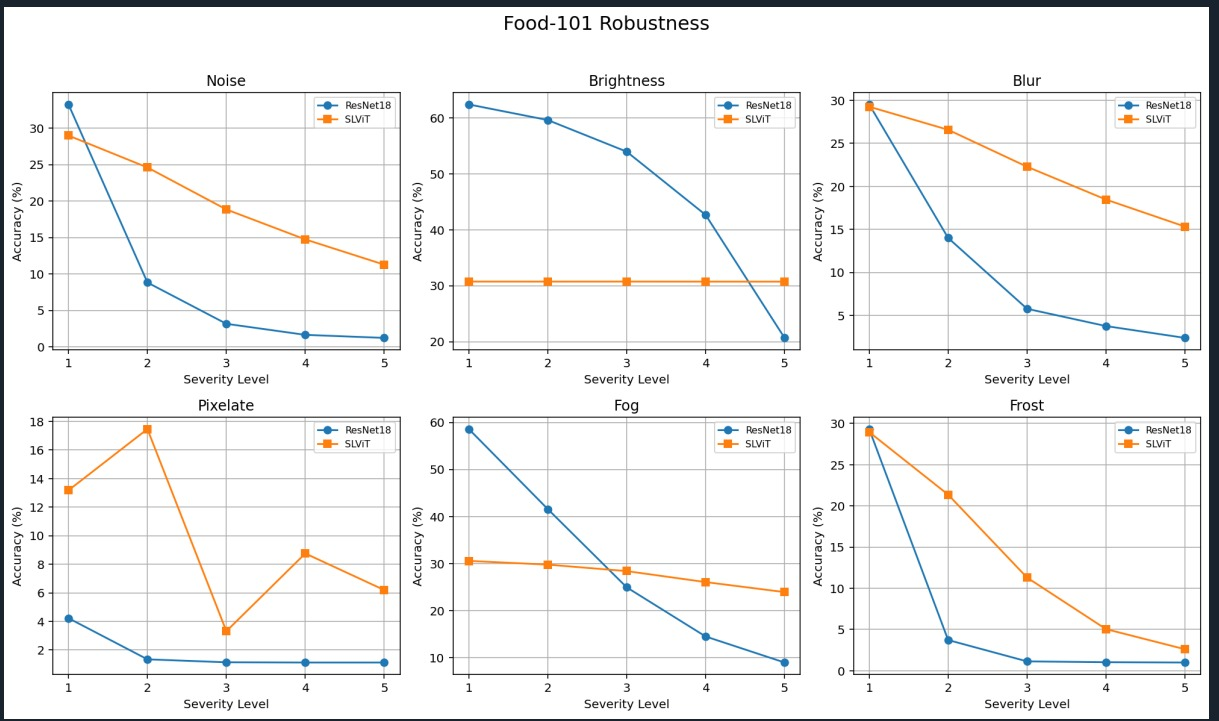

Since this takes a while to run we have included a visualisation as shown above, it clearly shows tht ...



# t-SNE on CIFAR-10 Gaussian noise
t-SNE is a really clear way to ...

In [ ]:
# Load your model definitions
from Resnet18 import ResNet18_CIFAR10   # adjust if class name differs
from SL_Vit import ViT                # adjust if class name differs

# Create feature models (no FC at the end)
feature_model_res = nn.Sequential(*list(model_res_acc.children())[:-1]).to(device)
feature_model_res.eval()

# For ViT → use CLS token BEFORE classifier
class ViT_FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x, return_embedding=True)  # only if forward() supports this

feature_model_vit = ViT_FeatureExtractor(model_vit_acc).to(device)
feature_model_vit.eval()


In [ ]:
def extract_features(model, dataloader, severity=None, max_samples=1200):
    features, labels = [], []
    count = 0

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            # Apply Gaussian blur if needed
            if severity is not None:
                imgs = defocus_blur(imgs, severity).to(device)

            feats = model(imgs)

            features.append(feats.cpu())
            labels.append(lbls.cpu())

            count += imgs.size(0)
            if count >= max_samples:
                break

    return torch.cat(features), torch.cat(labels)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features, labels = extract_features(feature_model_res, testloader, severity=None)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features.numpy())

classes = trainset.classes

plt.figure(figsize=(10,8))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1],
                      c=labels, cmap='tab10', s=15, alpha=0.7)

handles, _ = scatter.legend_elements()
plt.legend(handles, classes, title="Classes", loc="best")

plt.title("t-SNE of CIFAR10 (ResNet18 Features)")
plt.xlabel("TSNE - Dimension 1")
plt.ylabel("TSNE - Dimension 2")
plt.grid(alpha=0.4, linestyle='--')
plt.show()


# Limitations
We faced a few limitations within our project, which we will discuss in greater detail:
- Colab GPU limitations
- Time constraint
- Memory
- Knowledge of Neural Networks



# Results
 -Time
 -Accuracy
 -Loss


# References
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}


@ARTICLE{robustness,
  author={Kumar, Vishesh and Shukla, Shivam and Agarwal, Akshay},
  journal={IEEE Transactions on Big Data},
  title={Robustness Benchmarking of Convolutional and Transformer Architectures for Image Classification},
  year={2025},
  volume={11},
  number={6},
  pages={3330-3341},
  keywords={Robustness;Transformers;Image resolution;Image quality;Image classification;Distortion;Computer vision;Image coding;Deep learning;Benchmark testing;Corruption;convolution;transformer;robustness;explainability},
  doi={10.1109/TBDATA.2025.3593385}}
